<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2832 entries, 0 to 2831
Columns: 242 entries, bus to attack
dtypes: float64(237), int64(5)
memory usage: 5.2 MB
Shapes of processed tensors:
X_train: (2265, 238)
X_test: (567, 238)
y_train: (2265,)
y_test: (567,)
Epoch: 0, D Loss: 0.0760, G Loss: -0.0252
Epoch: 100, D Loss: -0.2779, G Loss: 0.1349
Epoch: 200, D Loss: -0.5286, G Loss: 0.3223
Epoch: 300, D Loss: -0.9061, G Loss: 0.4387
Epoch: 400, D Loss: -1.3008, G Loss: 0.6069
Epoch: 500, D Loss: -1.5199, G Loss: 0.7148
Epoch: 600, D Loss: -1.8878, G Loss: 0.8923
Epoch: 700, D Loss: -2.1456, G Loss: 1.0939
Epoch: 800, D Loss: -2.5279, G Loss: 1.0964
Epoch: 900, D Loss: -2.7978, G Loss: 1.3581
Epoch: 1000, D Loss: -3.0041, G Loss: 1.3778
Epoch: 1100, D Loss: -3.2826, G Loss: 1.4067
Epoch: 1200, D Loss: -3.2814, G Loss: 1.4448
Epoch: 1300, D Loss: -3.5493, G Loss: 1.5308
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


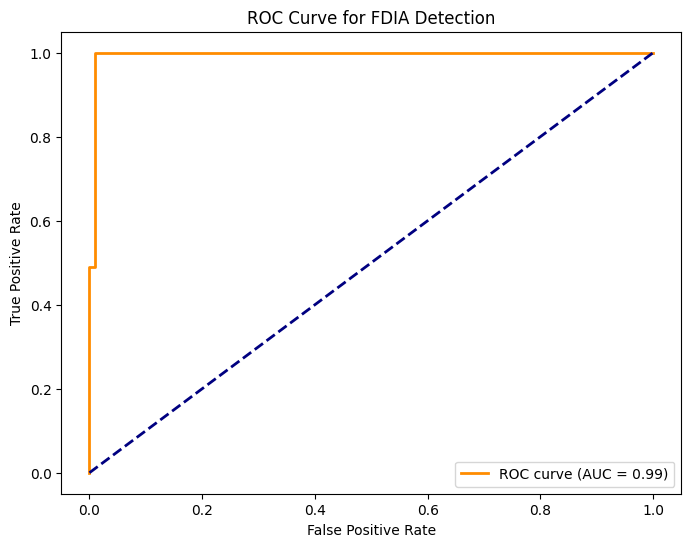

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Detection Accuracy: 0.9559
Detection Precision: 0.9491
Detection Recall: 1.0000
F1 Score: 0.9739
Detection Time: 0.2452 seconds


In [3]:
#SACGAN-GP
# Load and analyze the combined dataset to identify preprocessing needs
import pandas as pd

# Load the combined dataset with attacked and non-attacked data
combined_dataset_path = '/content/ieee118_fdia_dataset (8) (2).csv'
df = pd.read_csv(combined_dataset_path)

# Display basic information about the dataset to understand its structure
df_info = df.info()
df_head = df.head()

df_info, df_head

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Separate features (voltage and angle columns) and labels (attack column)
feature_columns = [col for col in df.columns if 'voltage' in col or 'angle' in col]
X = df[feature_columns]
y = df['attack']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Convert data into TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

print("Shapes of processed tensors:")
print("X_train:", X_train_tensor.shape)
print("X_test:", X_test_tensor.shape)
print("y_train:", y_train_tensor.shape)
print("y_test:", y_test_tensor.shape)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Embedding
from tensorflow.keras import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def build_cgan_generator(noise_dim, output_dim, num_classes=2):
    noise_input = Input(shape=(noise_dim,))
    label_input = Input(shape=(1,), dtype='int32')

    label_embedding = Embedding(num_classes, noise_dim)(label_input)
    label_embedding = Flatten()(label_embedding)

    combined_input = Concatenate()([noise_input, label_embedding])

    x = Dense(256, activation="relu")(combined_input)

    x = Dense(output_dim, activation="tanh")(x)
    return Model([noise_input, label_input], x)

def build_cgan_discriminator(input_dim, num_classes=2):
    data_input = Input(shape=(input_dim,))
    label_input = Input(shape=(1,), dtype='int32')

    label_embedding = Embedding(num_classes, input_dim)(label_input)
    label_embedding = Flatten()(label_embedding)

    combined_input = Concatenate()([data_input, label_embedding])

    x = Dense(256, activation="leaky_relu")(combined_input)

    x = Dense(1)(x)  # No activation for WGAN-GP

    return Model([data_input, label_input], x)

def gradient_penalty(real, fake, label, discriminator):
    alpha = tf.random.uniform([real.shape[0], 1], 0.0, 1.0)
    interpolated = alpha * real + (1 - alpha) * fake

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator([interpolated, label])

    gradients = tape.gradient(pred, [interpolated])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
    return tf.reduce_mean((slopes - 1.0) ** 2)

# Set up the GAN parameters
noise_dim = 100
output_dim = X_train.shape[1]
batch_size = 64
epochs = 1400
lambda_gp = 1 # Gradient penalty weight

# Instantiate generator and discriminator models
generator = build_cgan_generator(noise_dim, output_dim)
discriminator = build_cgan_discriminator(output_dim)

# Set optimizers
generator_optimizer = Adam(1e-6)
discriminator_optimizer = Adam(1e-6)

# Training loop
# Convert labels to tensors in the training loop
for epoch in range(epochs):
    for _ in range(5):  # Update discriminator more frequently
        # Sample random noise and labels
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        random_labels = np.random.randint(0, 2, batch_size)

        # Convert noise and random labels to tensors
        noise = tf.convert_to_tensor(noise, dtype=tf.float32)
        random_labels = tf.convert_to_tensor(random_labels, dtype=tf.int32)

        # Generate fake data conditioned on labels
        generated_data = generator([noise, random_labels])

        # Get a batch of real data and labels
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]
        real_labels = y_train.iloc[idx].values

        # Convert real labels to tensors
        real_data = tf.convert_to_tensor(real_data, dtype=tf.float32)
        real_labels = tf.convert_to_tensor(real_labels, dtype=tf.int32)

        # Train Discriminator with gradient penalty
        with tf.GradientTape() as tape:
            d_loss_real = tf.reduce_mean(discriminator([real_data, real_labels]))
            d_loss_fake = tf.reduce_mean(discriminator([generated_data, random_labels]))
            gp = gradient_penalty(real_data, generated_data, real_labels, discriminator)
            d_loss = d_loss_fake - d_loss_real + lambda_gp * gp

        gradients = tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    valid_labels = np.ones((batch_size,), dtype=int)  # Generate labels for attacked samples

    # Convert noise and valid labels to tensors
    noise = tf.convert_to_tensor(noise, dtype=tf.float32)
    valid_labels = tf.convert_to_tensor(valid_labels, dtype=tf.int32)

    with tf.GradientTape() as tape:
        g_loss = -tf.reduce_mean(discriminator([generator([noise, valid_labels]), valid_labels]))

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, D Loss: {d_loss.numpy():.4f}, G Loss: {g_loss.numpy():.4f}")


# Calculate anomaly scores for training and test sets
train_scores = discriminator.predict([X_train, y_train])
test_scores = discriminator.predict([X_test, y_test])

# Separate scores for attacked and non-attacked samples
train_scores_attacked = train_scores[y_train == 1]
train_scores_non_attacked = train_scores[y_train == 0]
test_scores_attacked = test_scores[y_test == 1]
test_scores_non_attacked = test_scores[y_test == 0]

from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, test_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for FDIA Detection")
plt.legend(loc="lower right")
plt.show()

import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Start timing
start_time = time.time()

# Generate anomaly scores for the test set
discriminator_scores = discriminator.predict([X_test, y_test])

# End timing
end_time = time.time()
detection_time = end_time - start_time

# Choose a threshold
threshold = np.percentile(discriminator_scores[y_test == 0], 75)
predicted_labels = (discriminator_scores > threshold).astype(int)

# Evaluation metrics
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

# Display results
print(f"Detection Accuracy: {accuracy:.4f}")
print(f"Detection Precision: {precision:.4f}")
print(f"Detection Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Detection Time: {detection_time:.4f} seconds")


